<a href="https://colab.research.google.com/github/prattband/harm_lexicon/blob/main/harm_lexicon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-docx --quiet


In [ ]:
# ------------  Cell 1 : load ALL docx transcripts ------------
from docx import Document
import glob, re, pandas as pd, pathlib, itertools

def parse_doc(path):
    """
    Very simple parser:
    - looks for lines that start with 00:MM:SS (time-code)
    - splits at first colon to get speaker + dialogue
    """
    doc = Document(path)
    rows = []
    ep_name = pathlib.Path(path).stem                # file name w/out extension
    time_re  = re.compile(r"^\d\d:\d\d:\d\d")

    for p in doc.paragraphs:
        line = p.text.strip()
        if not time_re.match(line):          # skip lines w/out time-code
            continue

        # split:   00:00:51 Cobel: Graner.
        parts = line.split(" ", 2)           # [time] [Speaker:] [rest]
        if len(parts) < 3:
            continue
        timecode, speaker_raw, dialog = parts
        speaker = speaker_raw.rstrip(":").upper().replace("  ", " ")

        rows.append((ep_name, timecode, speaker, dialog.strip()))

    return rows

# 🔎 grab *every* docx in the folder, whatever it’s called
files = glob.glob("*.docx")

all_rows = list(itertools.chain.from_iterable(parse_doc(f) for f in files))
df = pd.DataFrame(all_rows, columns=["episode", "time", "speaker", "dialogue"])

print("Loaded rows:", len(df))
print("Episodes found:", df["episode"].unique())
display(df.head())


Loaded rows: 956
Episodes found: ['In Perpetuity transcipt' 'Hide and Seek transcipt'
 'Whats for dinner transcript']


,episode,time,speaker,dialogue
0,In Perpetuity transcipt,00:00:10,MARK,"Petey, are you okay?"
1,In Perpetuity transcipt,00:00:17,MARK,Petey?
2,In Perpetuity transcipt,00:00:19,PETEY,"Yeah, I’m good. I just slipped. You should inv..."
3,In Perpetuity transcipt,00:00:25,MARK,"Yeah, okay. The robe is a gift from my brother..."
4,In Perpetuity transcipt,00:00:34,MARK,I have pillows. Do you need anything else?


In [ ]:
# ------------  Cell 2 : parse the transcripts  ------------

import re, pandas as pd
# skip if you already have a numeric time column
df['t_secs'] = pd.to_timedelta(df['time']).dt.total_seconds()

from pathlib import Path
from docx import Document

# ⇢ tweak here if your files live in another folder
FILES = list(Path(".").glob("*.docx"))
assert FILES, "No .docx files found – check the path!"

# regex: 00:00:51  NAME:  words…
PATTERN = re.compile(
    r'^(?P<time>\d{2}:\d{2}:\d{2})\s+'
    r'(?P<speaker>[A-Za-z .]+?):\s*'
    r'(?P<dialogue>.+)$'
)

rows = []
for file in FILES:
    doc = Document(file)
    for para in doc.paragraphs:
        line = para.text.strip()
        m = PATTERN.match(line)
        if not m:
            continue
        rows.append(
            {
                "episode": file.stem,                       # file name w/o .docx
                "time":    m["time"],
                # normalise speaker (upper-case, drop dots & double-spaces)
                "speaker": re.sub(r'\s+', ' ', m["speaker"]).replace(".", "").upper(),
                "dialogue": m["dialogue"].strip()
            }
        )

df = pd.DataFrame(rows)
print("→ parsed", len(df), "dialogue lines")
df.head()




→ parsed 923 dialogue lines


,episode,time,speaker,dialogue
0,In Perpetuity transcipt,00:00:10,MARK,"Petey, are you okay?"
1,In Perpetuity transcipt,00:00:17,MARK,Petey?
2,In Perpetuity transcipt,00:00:19,PETEY,"Yeah, I’m good. I just slipped. You should inv..."
3,In Perpetuity transcipt,00:00:25,MARK,"Yeah, okay. The robe is a gift from my brother..."
4,In Perpetuity transcipt,00:00:34,MARK,I have pillows. Do you need anything else?


In [ ]:
# ------------  Cell Y : re-flag with bigger pattern list & ALL speakers  ------------

import re

# 1) ★  BIGGER soft-coercion patterns  ★
coercion_patterns = [
    # polite or indirect imperatives
    r"\bplease\b",
    r"\bi (?:need|want) you to\b",          r"\byou (?:need|have) to\b",
    r"\byou must\b",                        r"\byou are to\b",
    r"\byou are required to\b",             r"\brequired\b",
    r"\bmake sure\b",                       r"\bensure that\b",
    # threats / accountability
    r"\bdo you understand\b",               r"\bunderstand\?\b",
    r"\b(be|are) accountable\b",            r"\bheld accountable\b",
    r"\bpunish(?:ed|ment)?\b",              r"\b(in|to) the break room\b",
    r"\bwill be disciplined\b",             r"\bconsequences\b",
    # quota / compliance language
    r"\bhit(quota)?\b",                     r"\bquota\b",
    r"\bget back to (?:work|your desk)\b",  r"\breturn to (?:your )?desk\b",
    r"\b(?:hallway|outside) privileges (?:are|is) (?:revoked|removed)\b",
    # formal duty / reporting
    r"\breport\b",                          r"\bself[- ]?report\b",
    r"\bsubmission\b",                      r"\bfile\b.*\brequest\b",
    r"\bfill out\b.*\bform\b",              r"\bofficial request\b",
    # hard-edge modal verbs
    r"\bshould\b",                          r"\bshall\b",
    # time pressure & commands
    r"\bimmediately\b",                     r"\bright now\b",
    r"\bat once\b",                         r"\bon you go\b",
    r"\bescort (?:him|her|them)\b",         r"\bsit\b.*\bplease\b",
    # appeals to company / founder authority
    r"\b(?:Kier|the board) (?:requires|wants|expects)\b",
    r"\bserve\b.*\bKier\b",
    # misc strong directives
    r"\bno more\b.*\b(?:visits|walking|talking)\b",
    r"\bstay there\b",                      r"\bdon't\b.*\b(?:move|sneak|ask)\b",
]

# 2)  Build a single regex (case-insensitive)
coercion_regex = re.compile("|".join(coercion_patterns), flags=re.IGNORECASE)

# 3)  Flag every line (ALL speakers, no filter now)
df["soft_coercion"] = df["dialogue"].str.contains(coercion_regex, na=False)

# 4)  How many did we catch this time?
hits = df["soft_coercion"].sum()
print(f"★ Total lines flagged as soft-coercion: {hits} / {len(df)}")

# 5)  Quick per-episode breakdown
display(
    df[df["soft_coercion"]]
      .groupby("episode")["dialogue"]
      .size()
      .rename("soft_coercion_lines")
      .reset_index()
      .sort_values("soft_coercion_lines", ascending=False)
)




★ Total lines flagged as soft-coercion: 67 / 923


,episode,soft_coercion_lines
1,In Perpetuity transcipt,28
0,Hide and Seek transcipt,23
2,Whats for dinner transcript,16


In [ ]:
# ------------  Cell Z : inspect flagged lines ------------

# Select just the interesting columns
sc = (
    df[df["soft_coercion"]]            # keep only flagged rows
      .loc[:, ["episode", "time", "speaker", "dialogue"]]
      .sort_values(["episode", "time"])   # neat chronological order
)

print(f"{len(sc):,} lines currently flagged as soft-coercion\n")

# 1) QUICK LOOK – first 30 rows
display(sc.head(30))

# 2) FULL TABLE – interactive, scrollable
#    (comment the next line out if your notebook slows down)
display(sc)     # pretty HTML table you can filter / sort

# 3) OPTIONAL: write just these to a new CSV for manual review
# sc.to_csv("/mnt/data/soft_coercion_only.csv", index=False)
# print("Saved → /mnt/data/soft_coercion_only.csv")



67 lines currently flagged as soft-coercion



,episode,time,speaker,dialogue
395,Hide and Seek transcipt,00:07:13,DEVON,You did so good. Now we’re gonna go home and s...
411,Hide and Seek transcipt,00:08:35,ANGELO,We should go.
417,Hide and Seek transcipt,00:09:36,IRVING,We should return to O&D immediately. All of us...
452,Hide and Seek transcipt,00:11:28,COBEL,Part-time Innies may not be as socialized and ...
454,Hide and Seek transcipt,00:11:44,MARK,"Because I snuck Helly out. I mean, if anyone s..."
456,Hide and Seek transcipt,00:11:57,COBEL,Who won’t you go to the break room for?
458,Hide and Seek transcipt,00:12:06,MARK,"Yes, but she shouldn’t be punished."
462,Hide and Seek transcipt,00:12:20,COBEL,Or were you sniffing around other departments ...
468,Hide and Seek transcipt,00:12:45,COBEL,"We serve Kier, you child!"
469,Hide and Seek transcipt,00:12:48,COBEL,And until you get that through your mildewed l...


,episode,time,speaker,dialogue
395,Hide and Seek transcipt,00:07:13,DEVON,You did so good. Now we’re gonna go home and s...
411,Hide and Seek transcipt,00:08:35,ANGELO,We should go.
417,Hide and Seek transcipt,00:09:36,IRVING,We should return to O&D immediately. All of us...
452,Hide and Seek transcipt,00:11:28,COBEL,Part-time Innies may not be as socialized and ...
454,Hide and Seek transcipt,00:11:44,MARK,"Because I snuck Helly out. I mean, if anyone s..."
...,...,...,...,...
808,Whats for dinner transcript,00:27:41,DYLAN,Two people. I’ll be fine. Can I have the stuff...
813,Whats for dinner transcript,00:28:20,MARK,I probably should’ve told you guys…
865,Whats for dinner transcript,00:39:59,RICKEN,Rebeck! She may be willing to share her copy w...
875,Whats for dinner transcript,00:40:29,MARK,"Hey, we should talk later. Devon: Yeah?"


In [ ]:
# -------------- Cell : role-split + fear/harm flag ----------------

import numpy as np
import re

### 1) Tell the notebook who is "employer" and who is "employee"
employer_speakers = [
    "COBEL", "MILCHICK", "NATALIE", "MS. CASEY", "CASEY",
    # add more bosses / board members if you want
]

employee_speakers = [
    "MARK", "HELLY", "DYLAN", "IRVING", "BURT", "PETEY",
    # add more floor workers, rebels, etc.
]

# quick sanity-check: if you forgot anyone
unknown_roles = set(df["speaker"]) - set(employer_speakers) - set(employee_speakers)
if unknown_roles:
    print("‼ Speakers with no role assigned →", unknown_roles)

### 2) Add a simple 'role' column
df["role"] = np.where(df["speaker"].isin(employer_speakers), "employer",
               np.where(df["speaker"].isin(employee_speakers), "employee", "unknown"))

### 3) Define harm / fear lexicon for employees
harmfear_patterns = [
    r"\bhurt\b", r"\bharm\b", r"\bscared\b", r"\bafraid\b",
    r"\bpunish(ed|ment)?\b", r"\bbreak room\b", r"\bfear\b",
    r"\bterror\b", r"\bkill\b", r"\bdie\b",
    # tweak / extend as needed
]

hf_regex = re.compile("|".join(harmfear_patterns), flags=re.IGNORECASE)

df["harm_fear"] = df.apply(
    lambda row: bool(hf_regex.search(row["dialogue"])) if row["role"] == "employee" else False,
    axis=1,
)

### 4) Build the two tables you asked for
employer_soft = (
    df[(df["role"] == "employer") & (df["soft_coercion"])]
      .loc[:, ["episode", "time", "speaker", "dialogue"]]
      .sort_values(["episode", "time"])
)

employee_harm = (
    df[(df["role"] == "employee") & (df["harm_fear"])]
      .loc[:, ["episode", "time", "speaker", "dialogue"]]
      .sort_values(["episode", "time"])
)

print(f"Employer soft-coercion lines: {len(employer_soft):,}")
display(employer_soft.head(30))      # first 30 for a glance
# display(employer_soft)             # uncomment for full interactive table

print(f"\nEmployee harm/fear lines: {len(employee_harm):,}")
display(employee_harm.head(30))
# display(employee_harm)             # uncomment for full table

employer_soft.to_csv("employer_soft_coercion.csv", index=False)
employee_harm.to_csv("employee_harm_fear.csv", index=False)
print("Saved in the notebook folder")


‼ Speakers with no role assigned → {'GUY AT VENUE', 'ANGELO', 'STEVEN', 'RICKEN', 'JUNE', 'ELIZABETH', 'ALEXA', 'LEAD SINGER', 'REGHABI', 'KIER EAGAN', 'MS CASEY', 'THE BOARD', 'GABBY', 'WAITER', 'GRANER', 'CHECKOUT GIRL', 'JUDD', 'DEVON', 'FELICIA'}
Employer soft-coercion lines: 20


,episode,time,speaker,dialogue
452,Hide and Seek transcipt,00:11:28,COBEL,Part-time Innies may not be as socialized and ...
456,Hide and Seek transcipt,00:11:57,COBEL,Who won’t you go to the break room for?
462,Hide and Seek transcipt,00:12:20,COBEL,Or were you sniffing around other departments ...
468,Hide and Seek transcipt,00:12:45,COBEL,"We serve Kier, you child!"
469,Hide and Seek transcipt,00:12:48,COBEL,And until you get that through your mildewed l...
530,Hide and Seek transcipt,00:20:47,COBEL,Escort him to the break room.
571,Hide and Seek transcipt,00:26:02,COBEL,You must be Devon.
579,Hide and Seek transcipt,00:26:28,COBEL,We should talk about different nursing positions.
182,In Perpetuity transcipt,00:24:09,MILCHICK,Did you fill out an official request for super...
255,In Perpetuity transcipt,00:30:31,NATALIE,"No, this is about Peter Kilmer. And I should t..."



Employee harm/fear lines: 15


,episode,time,speaker,dialogue
454,Hide and Seek transcipt,00:11:44,MARK,"Because I snuck Helly out. I mean, if anyone s..."
458,Hide and Seek transcipt,00:12:06,MARK,"Yes, but she shouldn’t be punished."
488,Hide and Seek transcipt,00:14:07,MARK,She’s in the break room.
516,Hide and Seek transcipt,00:17:54,MARK,"I mean, why won’t they tell us what we’re doin..."
13,In Perpetuity transcipt,00:01:08,IRVING,I still think an occasional mixer wouldn’t hur...
68,In Perpetuity transcipt,00:10:32,PETEY,You carry the hurt with you. You feel it down ...
86,In Perpetuity transcipt,00:13:09,HELLY,It’s good. It means you won’t get sent to the ...
153,In Perpetuity transcipt,00:22:09,HELLY,It literally causes fear.
229,In Perpetuity transcipt,00:28:44,DYLAN,It’s how you don’t die of boredom in the perpe...
279,In Perpetuity transcipt,00:33:05,HELLY,Did they ever kill anyone?


Saved in the notebook folder


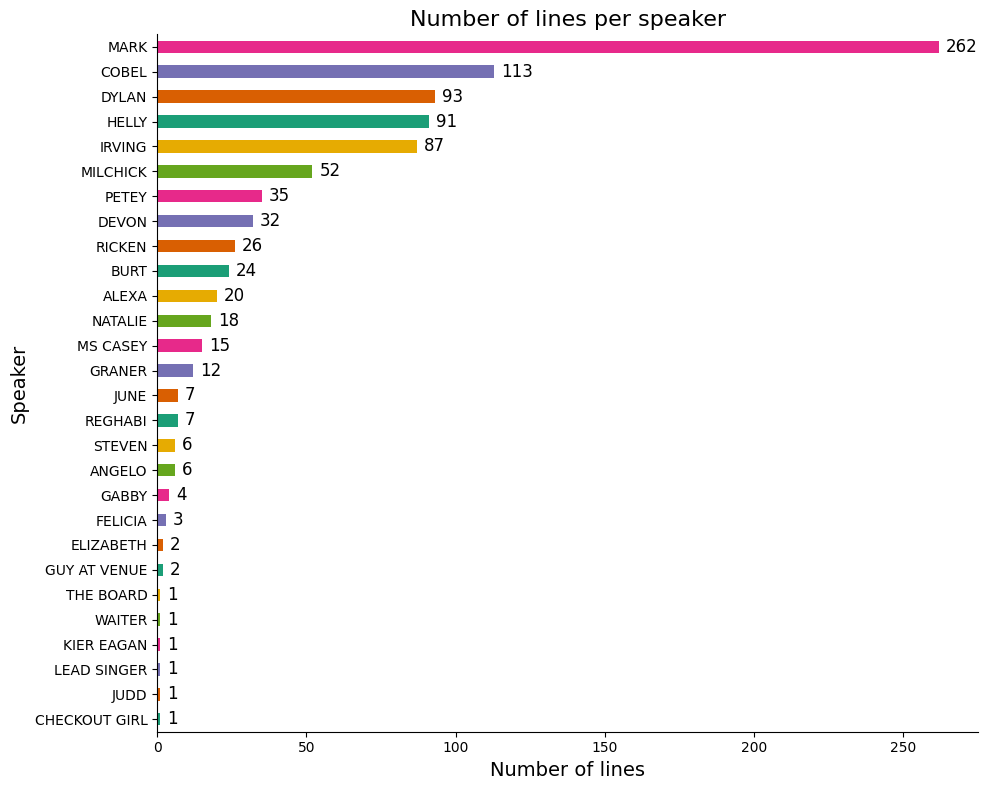

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# Increase figure size for better readability
plt.figure(figsize=(10, 8))

ax = df.groupby('speaker').size().sort_values().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Number of lines per speaker', fontsize=16)
plt.xlabel('Number of lines', fontsize=14)
plt.ylabel('Speaker', fontsize=14)

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=5, fontsize=12)

plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()

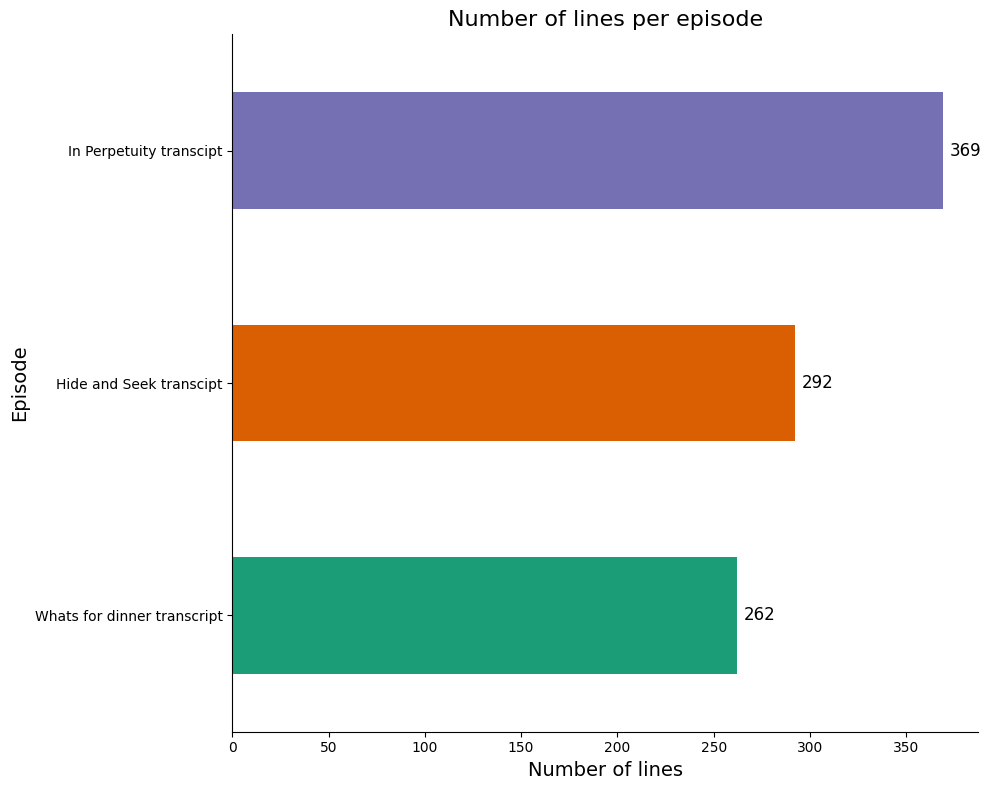

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# Increase figure size for better readability
plt.figure(figsize=(10, 8))

ax = df.groupby('episode').size().sort_values().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Number of lines per episode', fontsize=16)
plt.xlabel('Number of lines', fontsize=14)
plt.ylabel('Episode', fontsize=14)

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=5, fontsize=12)

plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()

In [ ]:
def label_power(row):
    if row["soft_coercion"] and row["role"]=="employer":
        return "Coercion"
    if row["harm_fear"] and row["role"]=="employee":
        return "Fear"
    return None                   # everything else = not counted

df["power_word"] = df.apply(label_power, axis=1)

In [ ]:
temp_df = df.dropna(subset=["power_word"])
print(temp_df["power_word"].unique())

pivot = (
    temp_df
      .groupby(["role", "power_word"])
      .size()
      .unstack(fill_value=0)
      .rename_axis(columns=None) # Remove the column index name
)

# Calculate total lines for each role from the pivot table
pivot["total_lines"] = pivot[["Coercion", "Fear"]].sum(axis=1)

# Calculate percentage of lines for each role
pivot["% of lines"] = ((pivot["Coercion"] + pivot["Fear"]) / pivot["total_lines"] * 100).round(1)

display(pivot)

['Fear' 'Coercion']


,Coercion,Fear,total_lines,% of lines
role,,,,
employee,0,15,15,100.0
employer,20,0,20,100.0


In [ ]:
pivot = (
    df.dropna(subset=["power_word"])            # keep only labelled rows
      .groupby(["role", "power_word"])
      .size()
      .unstack(fill_value=0)
      .assign(total_lines = lambda t: df.groupby("role")["dialogue"].size())
      .assign(**{
          "% of lines": lambda t: ((t["Coercion"].fillna(0)+t["Fear"].fillna(0))
                                   / t["total_lines"] * 100).round(1)
      })
)

display(pivot)


power_word,Coercion,Fear,total_lines,% of lines
role,,,,
employee,0,15,592,2.5
employer,20,0,183,10.9


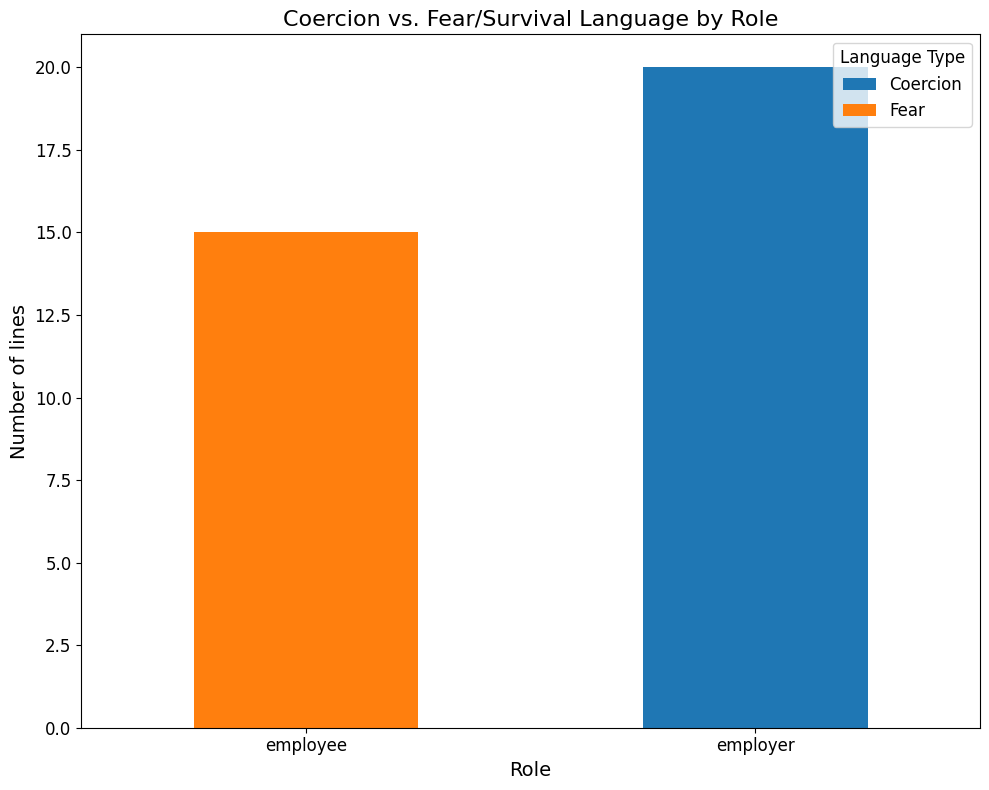

In [ ]:
plt.figure(figsize=(10, 8)) # Increase figure size
pivot[["Coercion","Fear"]].plot(kind="bar", stacked=True, ax=plt.gca()) # Use ax=plt.gca() to plot on the specified figure
plt.title("Coercion vs. Fear/Survival Language by Role", fontsize=16) # Add title
plt.ylabel("Number of lines", fontsize=14) # Add ylabel
plt.xlabel("Role", fontsize=14) # Add xlabel
plt.xticks(rotation=0, fontsize=12) # Adjust xticks font size
plt.yticks(fontsize=12) # Adjust yticks font size
plt.legend(title="Language Type", loc="upper right", fontsize=12, title_fontsize=12) # Adjust legend font sizes
plt.tight_layout() # Adjust layout
plt.show()

In [ ]:
# Add t_secs column if it doesn't exist
if "t_secs" not in df.columns:
    df['t_secs'] = pd.to_timedelta(df['time']).dt.total_seconds()

# ------------------------
# (A) explicit bracket cues
# ------------------------
silence_patterns = [
    r"\(silence\)", r"\(pause[s]?\)", r"\(no reply\)",
    r"\(stares\)",  r"\(looks (?:down|away)\)"
]
df['fear_action'] = df['dialogue'].str.contains('|'.join(silence_patterns),
                                                case=False, regex=True)

# -------------------------
# (B) missing-reply pause
# -------------------------
df['fear_silence'] = False          # initialise
coercive_mgr = df['soft_coercion'] & (df['role'] == 'Employer')

for idx in df[coercive_mgr].index:
    if idx+1 not in df.index:        # last line – skip
        continue
    next_row = df.loc[idx+1]
    # (1) manager speaks again OR (2) explicit stage direction row
    if (next_row['speaker'] == df.loc[idx, 'speaker']) \
       or (isinstance(next_row['speaker'], str) and next_row['speaker'].startswith('(')):
        df.at[idx+1, 'fear_silence'] = True

# ------------------------
# (C) long pause > 5 s
# ------------------------
df['delta_next'] = df['t_secs'].shift(-1) - df['t_secs']
pause_mask = coercive_mgr & (df['delta_next'] > 5)
df.loc[pause_mask, 'fear_silence'] = True

In [ ]:
df['any_fear'] = df[['harm_fear', 'fear_action', 'fear_silence']].any(axis=1)


In [ ]:
# --- 0)  Make sure df already has these columns -------------
# df['role']           ∈ {'employer','employee','unknown'}
# df['soft_coercion']  bool  (your coercion regex flag)
# df['any_fear']       bool  (your harm-/fear-related flag)

# --- 1)  NEW boolean columns based on your rule -------------
df['is_coercion'] = (df['role'] == 'employer') & df['soft_coercion']

# For employees: treat *any* flagged line as fear/survival
df['is_fear'] = (df['role'] == 'employee') & (df['soft_coercion'] | df['any_fear'])

# --- 2)  Summary table --------------------------------------
summary = (
    df.groupby('role')
      .agg(total_lines = ('dialogue',   'size'),
           coercion     = ('is_coercion','sum'),
           fear_surv    = ('is_fear',    'sum'))
)

summary['% coercion'] = (summary['coercion']  / summary['total_lines'] * 100).round(1)
summary['% fear']     = (summary['fear_surv'] / summary['total_lines'] * 100).round(1)

summary = summary.reset_index()
summary



,role,total_lines,coercion,fear_surv,% coercion,% fear
0,employee,592,0,48,0.0,8.1
1,employer,183,20,0,10.9,0.0
2,unknown,148,0,0,0.0,0.0


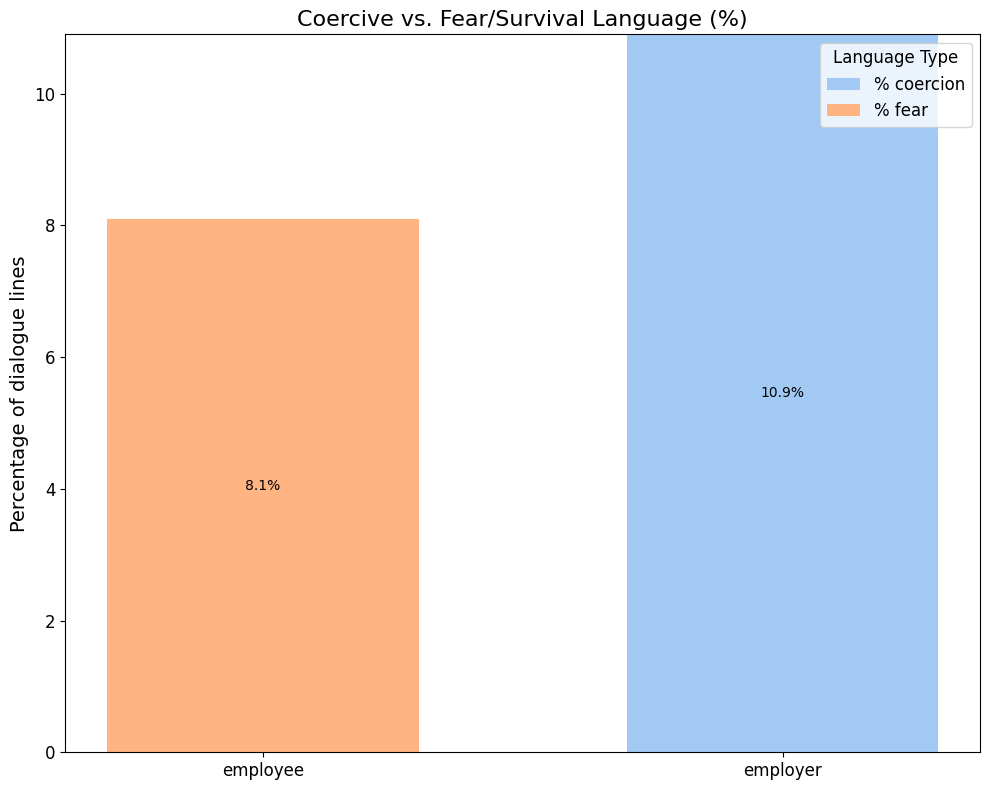

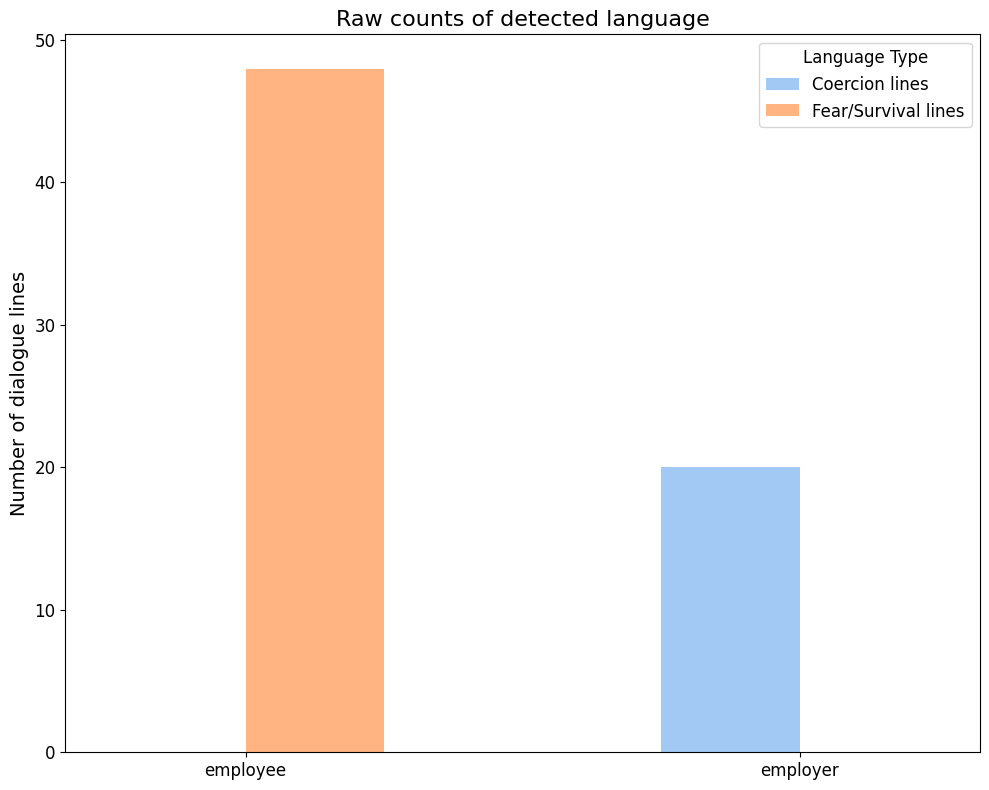

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn for color palettes

# ---- Sample summary DataFrame (replace with your actual summary variable) ----
summary = pd.DataFrame({
    'role': ['employee', 'employer', 'unknown'],
    'total_lines': [592, 183, 148],
    'coercion': [0, 20, 0],
    'fear_surv': [48, 0, 0],
})
summary['% coercion'] = (summary['coercion'] / summary['total_lines'] * 100).round(1)
summary['% fear'] = (summary['fear_surv'] / summary['total_lines'] * 100).round(1)

# If you'd prefer to drop the "unknown" group from the visuals:
plot_df = summary[summary['role'] != 'unknown'].copy()

# -----------------------------------------------------------------------------
# 1) Percentages plot
plt.figure(figsize=(10, 8)) # Increased figure size
x = range(len(plot_df))

# Use a soothing color palette from seaborn
colors = sns.color_palette("pastel", 2)

bars1 = plt.bar(x, plot_df['% coercion'], label='% coercion', color=colors[0], width=0.6) # Reduced bar width
bars2 = plt.bar(x, plot_df['% fear'], bottom=plot_df['% coercion'], label='% fear', color=colors[1], width=0.6) # Reduced bar width

plt.xticks(x, plot_df['role'], fontsize=12) # Adjusted xticks font size
plt.yticks(fontsize=12) # Adjusted yticks font size
plt.ylabel('Percentage of dialogue lines', fontsize=14) # Adjusted ylabel font size
plt.title('Coercive vs. Fear/Survival Language (%)', fontsize=16) # Adjusted title font size
plt.legend(loc='upper right', title="Language Type", fontsize=12, title_fontsize=12) # Adjusted legend font sizes
plt.tight_layout() # Adjust layout

# Add data labels
for bar in bars1:
    yval = bar.get_height()
    if yval > 0: # Only add label if the value is greater than 0
        plt.text(bar.get_x() + bar.get_width()/2, yval/2, f'{yval:.1f}%', va='center', ha='center', fontsize=10, color='black') # Position label in the middle of the bar

for bar in bars2:
    yval = bar.get_height()
    if yval > 0: # Only add label if the value is greater than 0
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_y() + yval/2, f'{yval:.1f}%', va='center', ha='center', fontsize=10, color='black') # Position label in the middle of the bar


plt.show()

# -----------------------------------------------------------------------------
# 2) Raw counts plot
plt.figure(figsize=(10, 8)) # Increase figure size
bar_width = 0.25 # Reduced bar width
x = range(len(plot_df))

# Use a soothing color palette from seaborn
colors = sns.color_palette("pastel", 2)

plt.bar([i - bar_width/2 for i in x], plot_df['coercion'],
        width=bar_width, label='Coercion lines', color=colors[0])
plt.bar([i + bar_width/2 for i in x], plot_df['fear_surv'],
        width=bar_width, label='Fear/Survival lines', color=colors[1])

plt.xticks(x, plot_df['role'], fontsize=12) # Adjust xticks font size
plt.yticks(fontsize=12) # Adjust yticks font size
plt.ylabel('Number of dialogue lines', fontsize=14) # Add ylabel
plt.title('Raw counts of detected language', fontsize=16) # Add title
plt.legend(loc='upper right', title="Language Type", fontsize=12, title_fontsize=12) # Adjust legend font sizes
plt.tight_layout() # Adjust layout
plt.show()

# New Section

Top candidate terms:


In [ ]:
!pip install pdfplumber --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 38.8 MB/s eta 0:00:00


In [ ]:
import pdfplumber

In [ ]:
from collections import Counter
import re

# Filter the DataFrame to get only the soft coercion lines
soft_coercion_dialogue = df[df['soft_coercion']]['dialogue']

# Combine all dialogue into a single string
all_soft_coercion_text = " ".join(soft_coercion_dialogue)

# Tokenize the text into words and convert to lowercase
words = re.findall(r'\b\w+\b', all_soft_coercion_text.lower())

# Remove common English stop words (optional, but can help focus on more meaningful words)
# You might want to customize this list based on your domain
stop_words = set([
    'the', 'a', 'an', 'is', 'it', 'in', 'of', 'on', 'and', 'to', 'be', 'that',
    'have', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'this', 'that',
    'here', 'there', 'all', 'any', 'both', 'each', 'few', 'more', 'most',
    'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
    'than', 'too', 'very', 'can', 'will', 'just', 'don', 'should', 'now',
    'get', 'back', 'your', 'to', 'in', 'the', 'a', 'and', 'of', 'i', 'you',
    'it', 'is', 'that', 'on', 'be', 'have', 'with', 'for', 'as', 'do', 'at',
    'this', 'but', 'by', 'from', 'or', 'not', 'he', 'she', 'they', 'we',
    'his', 'her', 'their', 'my', 'me', 'us', 'him', 'out', 'up', 'down',
    'if', 'then', 'so', 'about', 'into', 'through', 'during', 'before',
    'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out',
    'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
    'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both',
    'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor',
    'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't',
    'can', 'will', 'just', 'don', 'should', 'now', 'd', 'll', 'm', 'o',
    're', 've', 'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn',
    'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan',
    'shouldn', 'wasn', 'weren', 'won', 'wouldn', 'please' # Added 'please' as it's in the lexicon but might be too common
])

words = [word for word in words if word not in stop_words]

# Count the frequency of each word
word_counts = Counter(words)

# Get the most common words
most_common_words = word_counts.most_common(20) # Display the top 20

print("Most common words in soft coercion dialogue (excluding common stop words):")
for word, count in most_common_words:
    print(f"{word}: {count}")

Most common words in soft coercion dialogue (excluding common stop words):
go: 9
right: 6
am: 6
quota: 6
break: 5
room: 5
been: 5
helly: 5
maybe: 4
sorry: 4
mark: 4
may: 4
department: 4
yeah: 3
good: 3
shall: 3
know: 3
see: 3
perpetuity: 3
wing: 3


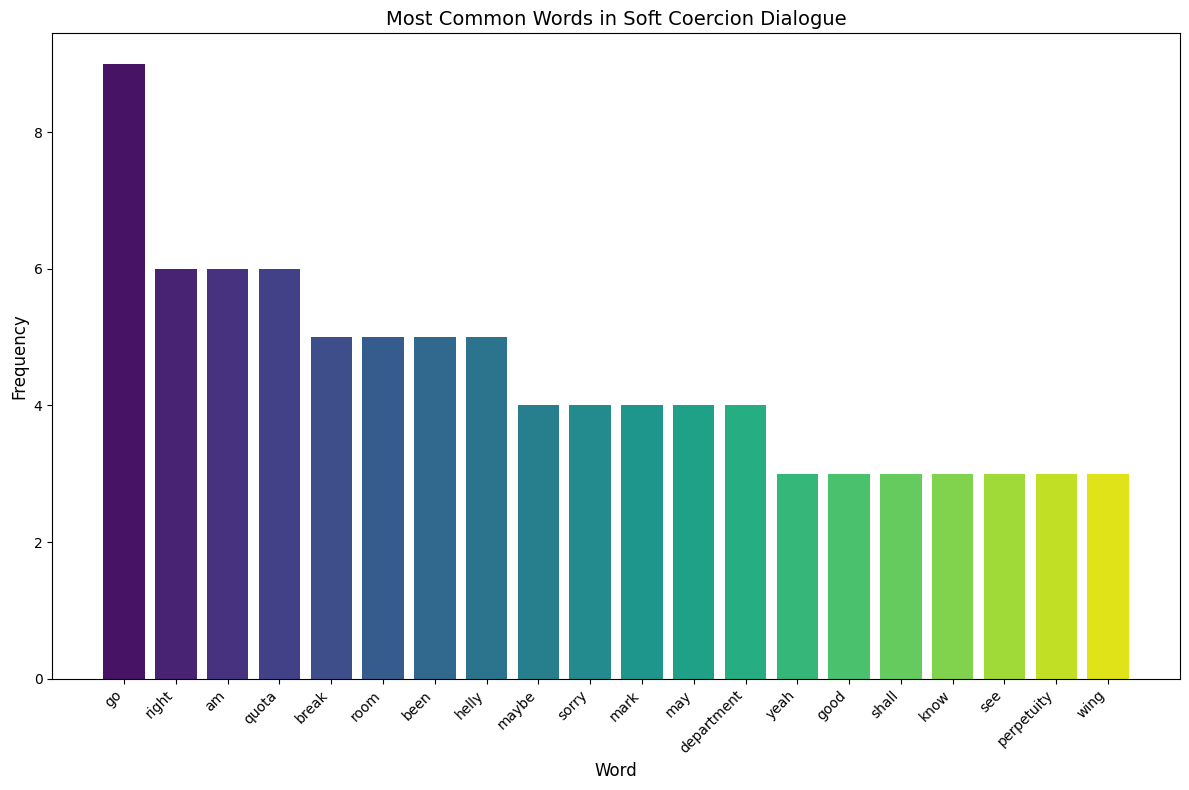

In [ ]:
# Ensure most_common_words is available from the previous step
if 'most_common_words' in locals():
    words, counts = zip(*most_common_words)

    plt.figure(figsize=(12, 8))
    plt.bar(words, counts, color=sns.color_palette("viridis", len(words))) # Use a different color palette
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel("Word", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title("Most Common Words in Soft Coercion Dialogue", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Please run the previous cell to generate 'most_common_words' first.")

In [ ]:
# 1. Verify or create the 't_secs' column
if "t_secs" not in df.columns:
    df['t_secs'] = pd.to_timedelta(df['time']).dt.total_seconds()

# 2. Sort the DataFrame by episode and time
df = df.sort_values(by=['episode', 't_secs']).reset_index(drop=True)

# 3. Calculate cumulative time across episodes
# Find the start time for each episode (which is the first 't_secs' after sorting)
episode_start_times = df.groupby('episode')['t_secs'].min().reset_index()
episode_start_times['episode_start_offset'] = episode_start_times['t_secs'].cumsum() - episode_start_times['t_secs']

# Merge the start offsets back to the main DataFrame
df = pd.merge(df, episode_start_times[['episode', 'episode_start_offset']], on='episode', how='left')

# Calculate the cumulative time
df['cumulative_t_secs'] = df['t_secs'] + df['episode_start_offset']

# Display the first few rows with the new column
display(df[['episode', 'time', 't_secs', 'episode_start_offset', 'cumulative_t_secs']].head())

,episode,time,t_secs,episode_start_offset,cumulative_t_secs
0,Hide and Seek transcipt,00:00:51,51.0,0.0,51.0
1,Hide and Seek transcipt,00:00:52,52.0,0.0,52.0
2,Hide and Seek transcipt,00:00:57,57.0,0.0,57.0
3,Hide and Seek transcipt,00:00:59,59.0,0.0,59.0
4,Hide and Seek transcipt,00:01:02,62.0,0.0,62.0


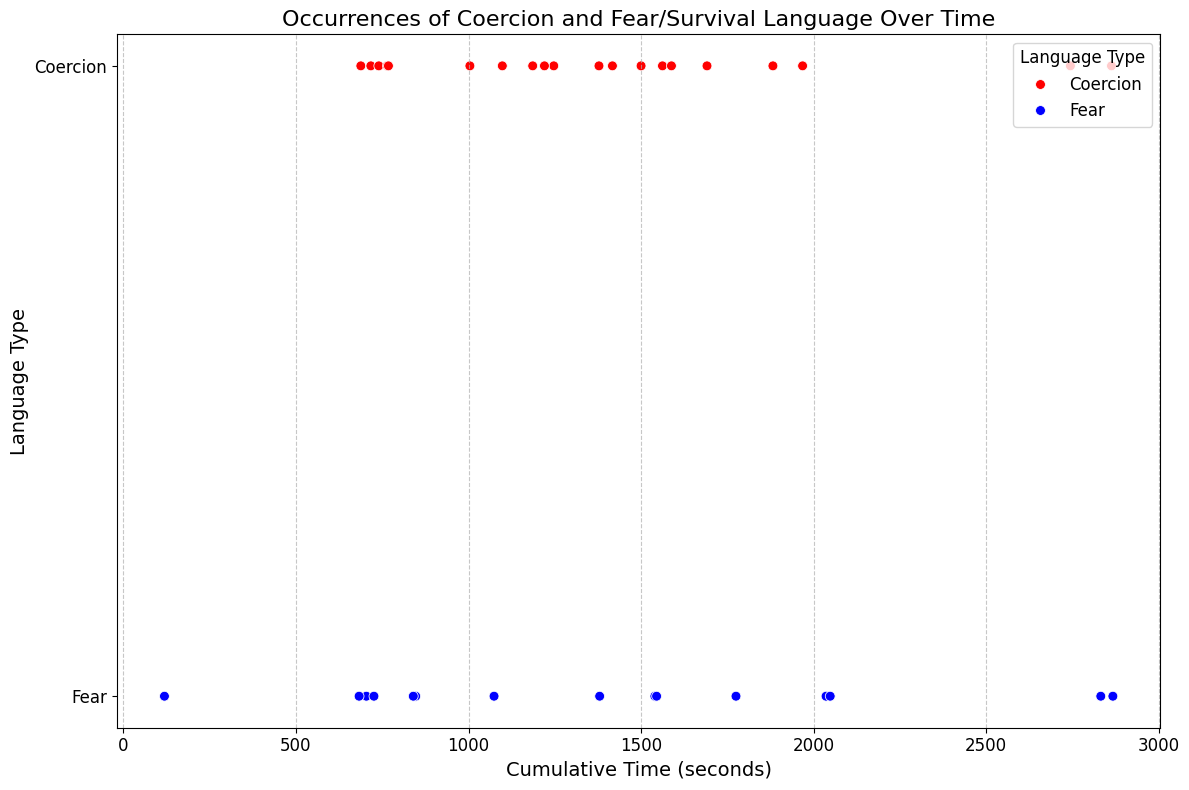

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the DataFrame to include only rows where either is_coercion or is_fear is True.
plot_data = df[(df['is_coercion'] | df['is_fear'])].copy()

# Create a scatter plot
plt.figure(figsize=(12, 8)) # Increase figure size
sns.scatterplot(data=plot_data, x='cumulative_t_secs', y='power_word', hue='power_word', palette={'Coercion': 'red', 'Fear': 'blue'}, s=50)

plt.title('Occurrences of Coercion and Fear/Survival Language Over Time', fontsize=16)
plt.xlabel('Cumulative Time (seconds)', fontsize=14)
plt.ylabel('Language Type', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7) # Add a grid for better readability
plt.legend(title='Language Type', loc='upper right', fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.show()